# Deep Q Network(DQN)

- Q 네트워크를 DQN으로 만드는 방법
  1. 단일 네트워크를 다계층 합성곱 네트워크(CNN)로 확장
  2. 경험 리플레이의 구현
  3. 제2의 타깃 네트워크를 활용하여 업데이트 시 타깃 Q 값을 계산

# Double DQN(DDQN)

- 학습 단계에서 타깃 Q 값을 계산할 때 Q 값들에서 최댓값을 구하는 대신, 제 1 네트워크를 이용해 액션을 선택하고,해당 액션에 대한 타깃 Q 값을 타깃 네트워크에서 생성하는 방법
- DDQN 방정식 : ${ Q }_{ target }=r+\gamma Q\left( s',argmax\left( Q\left( s',a,\theta  \right) ,\theta ' \right)  \right) $

# Dueling DQN

- $Q\left( s,a \right) =V\left( s \right) +A\left( a \right) $
  - V(s) : 가치 함수(value function)으로 단순히 어떤 상태가 얼마나 좋은지 수치화한 것
  - A(a) : 어드밴티지 함수로 다른 액션에 비해 특정 액션을 취하는 것이 얼마나 좋은지를 수치화한 것
- Dueling DQN은 가치와 어드밴티지를 분리하여 계산한 뒤 마지막 계층에서 조합하여 하나의 Q함수로 만들어주는 네트워크이다.

# 그리드 세계 구현
- [gridworld.py](https://github.com/awjuliani/DeepRL-Agents/blob/master/gridworld.py)

# 구현

### 라이브러리 로딩

In [1]:
import gym
import numpy as np
import random
import tensorflow as tf
import tensorflow.contrib.slim as slim
import matplotlib.pyplot as plt
import scipy.misc
import os
%matplotlib inline

### 게임 환경 로딩

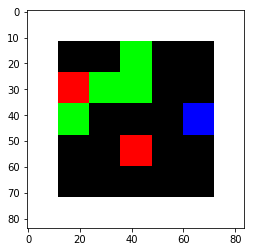

In [2]:
from gridworld import gameEnv

env = gameEnv(partial=False, size=5)

### 네트워크 만들기

In [3]:
class Qnetwork():
    def __init__(self, h_size):
        self.scalarInput = tf.placeholder(shape=[None,21168], dtype=tf.float32)
        self.imageIn = tf.reshape(self.scalarInput, shape=[-1,84,84,3])
        self.conv1 = slim.conv2d(inputs=self.imageIn,num_outputs=32,kernel_size=[8,8],stride=[4,4],\
                                padding='VALID', biases_initializer=None)
        self.conv2 = slim.conv2d(inputs=self.conv1,num_outputs=64,kernel_size=[4,4],stride=[2,2],\
                                padding='VALID', biases_initializer=None)
        self.conv3 = slim.conv2d(inputs=self.conv2,num_outputs=64,kernel_size=[3,3],stride=[1,1],\
                                padding='VALID', biases_initializer=None)
        self.conv4 = slim.conv2d(inputs=self.conv3,num_outputs=h_size,kernel_size=[7,7],stride=[1,1],\
                                padding='VALID', biases_initializer=None)
        
        self.streamAC, self.streamVC = tf.split(self.conv4,2,3)
        self.streamA = slim.flatten(self.streamAC)
        self.streamV = slim.flatten(self.streamVC)
        self.AW = tf.Variable(tf.random_normal([h_size//2, env.actions]))
        self.VW = tf.Variable(tf.random_normal([h_size//2, 1]))
        self.Advantage = tf.matmul(self.streamA, self.AW)
        self.Value = tf.matmul(self.streamV, self.VW)
        
        self.Qout = self.Value + tf.subtract(self.Advantage, tf.reduce_mean(self.Advantage, axis=1, keep_dims=True))
        self.predict = tf.argmax(self.Qout, 1)
        
        self.targetQ = tf.placeholder(shape=[None], dtype=tf.float32)
        self.actions = tf.placeholder(shape=[None], dtype=tf.int32)
        self.actions_onehot = tf.one_hot(self.actions, env.actions, dtype=tf.float32)
        
        self.Q = tf.reduce_sum(tf.multiply(self.Qout, self.actions_onehot), axis=1)
        
        self.td_error = tf.square(self.targetQ - self.Q)
        self.loss = tf.reduce_mean(self.td_error)
        self.trainer = tf.train.AdamOptimizer(learning_rate=0.0001)
        self.updateModel = self.trainer.minimize(self.loss)

### 경험 리플레이

In [4]:
class experience_buffer():
    def __init__(self, buffer_size = 50000):
        self.buffer = []
        self.buffer_size = buffer_size
        
    def add(self, experience):
        if len(self.buffer) + len(experience) >= self.buffer_size:
            self.buffer[0:(len(experience) + len(self.buffer) - self.buffer_size)] = []
        self.buffer.extend(experience)
        
    def sample(self, size):
        return np.reshape(np.array(random.sample(self.buffer, size)), [size, 5])

### 게임의 프레임 크기 재조절

In [5]:
def processState(states):
    return np.reshape(states,[21168])

### 타겟 네트워크의 매개변수를 업데이트

In [6]:
def updateTargetGraph(tfVars,tau):
    total_vars = len(tfVars)
    op_holder = []
    for idx,var in enumerate(tfVars[0:total_vars//2]):
        op_holder.append(tfVars[idx+total_vars//2].assign((var.value()*tau) + ((1-tau)*tfVars[idx+total_vars//2].value())))
    return op_holder

def updateTarget(op_holder,sess):
    for op in op_holder:
        sess.run(op)

### 네트워크 학습

In [7]:
batch_size = 32 
update_freq = 4 
y = .99 
startE = 1 
endE = 0.1 
annealing_steps = 10000 
num_episodes = 10000 
pre_train_steps = 10000 
max_epLength = 50 
load_model = False 
path = "./dqn" 
h_size = 512 
tau = 0.001 

In [8]:
tf.reset_default_graph()
mainQN = Qnetwork(h_size)
targetQN = Qnetwork(h_size)

init = tf.global_variables_initializer()

saver = tf.train.Saver()

trainables = tf.trainable_variables()

targetOps = updateTargetGraph(trainables,tau)

myBuffer = experience_buffer()

e = startE
stepDrop = (startE - endE)/annealing_steps

jList = []
rList = []
total_steps = 0

if not os.path.exists(path):
    os.makedirs(path)

with tf.Session() as sess:
    sess.run(init)
    if load_model == True:
        print('Loading Model...')
        ckpt = tf.train.get_checkpoint_state(path)
        saver.restore(sess,ckpt.model_checkpoint_path)
    for i in range(num_episodes):
        episodeBuffer = experience_buffer()
        s = env.reset()
        s = processState(s)
        d = False
        rAll = 0
        j = 0
        while j < max_epLength: 
            j+=1
            if np.random.rand(1) < e or total_steps < pre_train_steps:
                a = np.random.randint(0,4)
            else:
                a = sess.run(mainQN.predict,feed_dict={mainQN.scalarInput:[s]})[0]
            s1,r,d = env.step(a)
            s1 = processState(s1)
            total_steps += 1
            episodeBuffer.add(np.reshape(np.array([s,a,r,s1,d]),[1,5])) 
            
            if total_steps > pre_train_steps:
                if e > endE:
                    e -= stepDrop
                
                if total_steps % (update_freq) == 0:
                    trainBatch = myBuffer.sample(batch_size) 
                    Q1 = sess.run(mainQN.predict,feed_dict={mainQN.scalarInput:np.vstack(trainBatch[:,3])})
                    Q2 = sess.run(targetQN.Qout,feed_dict={targetQN.scalarInput:np.vstack(trainBatch[:,3])})
                    end_multiplier = -(trainBatch[:,4] - 1)
                    doubleQ = Q2[range(batch_size),Q1]
                    targetQ = trainBatch[:,2] + (y*doubleQ * end_multiplier)
                    _ = sess.run(mainQN.updateModel, \
                        feed_dict={mainQN.scalarInput:np.vstack(trainBatch[:,0]),mainQN.targetQ:targetQ, mainQN.actions:trainBatch[:,1]})
                    
                    updateTarget(targetOps,sess) 
            rAll += r
            s = s1
            
            if d == True:

                break
        
        myBuffer.add(episodeBuffer.buffer)
        jList.append(j)
        rList.append(rAll)
        if i % 1000 == 0:
            saver.save(sess,path+'/model-'+str(i)+'.ckpt')
            print("Saved Model")
        if len(rList) % 10 == 0:
            print(total_steps,np.mean(rList[-10:]), e)
    saver.save(sess,path+'/model-'+str(i)+'.ckpt')
print("Percent of succesful episodes: " + str(sum(rList)/num_episodes) + "%")

Instructions for updating:
keep_dims is deprecated, use keepdims instead
Saved Model
500 1.6 1
1000 2.0 1
1500 0.0 1
2000 2.7 1
2500 2.1 1
3000 2.6 1
3500 2.4 1
4000 2.0 1
4500 1.8 1
5000 3.0 1
5500 0.6 1
6000 1.2 1
6500 2.5 1
7000 1.5 1
7500 2.2 1
8000 1.4 1
8500 1.7 1
9000 1.6 1
9500 2.2 1
10000 2.3 1
10500 2.1 0.9549999999999828
11000 1.3 0.9099999999999655
11500 2.8 0.8649999999999483
12000 1.4 0.819999999999931
12500 1.6 0.7749999999999138
13000 2.4 0.7299999999998965
13500 1.3 0.6849999999998793
14000 2.0 0.639999999999862
14500 2.1 0.5949999999998448
15000 0.9 0.5499999999998275
15500 1.2 0.5049999999998103
16000 0.7 0.4599999999998177
16500 2.3 0.41499999999982823
17000 1.1 0.36999999999983874
17500 0.2 0.32499999999984924
18000 0.9 0.27999999999985975
18500 0.9 0.23499999999986562
19000 1.0 0.18999999999986225
19500 1.2 0.14499999999985888
20000 0.6 0.09999999999985551
20500 1.0 0.09999999999985551
21000 0.5 0.09999999999985551
21500 1.5 0.09999999999985551
22000 0.0 0.0999999

136500 21.9 0.09999999999985551
137000 19.6 0.09999999999985551
137500 19.7 0.09999999999985551
138000 17.9 0.09999999999985551
138500 19.7 0.09999999999985551
139000 16.3 0.09999999999985551
139500 20.9 0.09999999999985551
140000 20.7 0.09999999999985551
140500 20.2 0.09999999999985551
141000 21.0 0.09999999999985551
141500 23.4 0.09999999999985551
142000 20.5 0.09999999999985551
142500 19.8 0.09999999999985551
143000 19.0 0.09999999999985551
143500 17.6 0.09999999999985551
144000 19.2 0.09999999999985551
144500 19.7 0.09999999999985551
145000 21.5 0.09999999999985551
145500 23.0 0.09999999999985551
146000 18.9 0.09999999999985551
146500 17.5 0.09999999999985551
147000 21.0 0.09999999999985551
147500 21.4 0.09999999999985551
148000 18.3 0.09999999999985551
148500 20.6 0.09999999999985551
149000 19.1 0.09999999999985551
149500 22.5 0.09999999999985551
150000 24.2 0.09999999999985551
Saved Model
150500 21.7 0.09999999999985551
151000 22.5 0.09999999999985551
151500 21.8 0.09999999999985

264000 22.3 0.09999999999985551
264500 21.7 0.09999999999985551
265000 20.2 0.09999999999985551
265500 20.6 0.09999999999985551
266000 22.4 0.09999999999985551
266500 22.2 0.09999999999985551
267000 25.0 0.09999999999985551
267500 23.3 0.09999999999985551
268000 22.4 0.09999999999985551
268500 23.8 0.09999999999985551
269000 22.3 0.09999999999985551
269500 21.0 0.09999999999985551
270000 21.9 0.09999999999985551
270500 22.8 0.09999999999985551
271000 21.3 0.09999999999985551
271500 18.0 0.09999999999985551
272000 24.0 0.09999999999985551
272500 23.3 0.09999999999985551
273000 24.1 0.09999999999985551
273500 22.8 0.09999999999985551
274000 23.0 0.09999999999985551
274500 23.5 0.09999999999985551
275000 22.5 0.09999999999985551
275500 22.0 0.09999999999985551
276000 21.4 0.09999999999985551
276500 23.0 0.09999999999985551
277000 24.8 0.09999999999985551
277500 22.7 0.09999999999985551
278000 22.6 0.09999999999985551
278500 22.8 0.09999999999985551
279000 23.4 0.09999999999985551
279500 2

392000 21.0 0.09999999999985551
392500 22.4 0.09999999999985551
393000 22.5 0.09999999999985551
393500 24.1 0.09999999999985551
394000 22.9 0.09999999999985551
394500 24.4 0.09999999999985551
395000 21.8 0.09999999999985551
395500 21.6 0.09999999999985551
396000 24.9 0.09999999999985551
396500 22.9 0.09999999999985551
397000 22.8 0.09999999999985551
397500 23.6 0.09999999999985551
398000 22.7 0.09999999999985551
398500 23.1 0.09999999999985551
399000 22.6 0.09999999999985551
399500 24.5 0.09999999999985551
400000 22.7 0.09999999999985551
Saved Model
400500 21.5 0.09999999999985551
401000 24.1 0.09999999999985551
401500 22.0 0.09999999999985551
402000 20.5 0.09999999999985551
402500 22.3 0.09999999999985551
403000 22.2 0.09999999999985551
403500 21.5 0.09999999999985551
404000 23.0 0.09999999999985551
404500 23.1 0.09999999999985551
405000 24.3 0.09999999999985551
405500 23.1 0.09999999999985551
406000 22.1 0.09999999999985551
406500 21.8 0.09999999999985551
407000 23.9 0.09999999999985

### 시각화

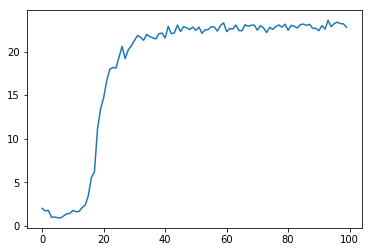

In [9]:
rMat = np.resize(np.array(rList),[len(rList)//100,100])
rMean = np.average(rMat,1)
plt.plot(rMean)